In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from planners.basic_prm import BasicPRM
from utils.collision_checker import CollisionChecker
from environment import get_all_scenes
import time
import pandas as pd
from scipy.spatial.distance import euclidean

In [2]:
def visualize_path(prm, path, scene, limits, start, goal, title=""):
    fig, ax = plt.subplots(figsize=(8, 8))

    # Hindernisse zeichnen
    for shape in scene.values():
        xs, ys = shape.exterior.xy if hasattr(shape, 'exterior') else shape.xy
        ax.fill(xs, ys, color='lightcoral', alpha=0.7)

    pos = nx.get_node_attributes(prm.graph, 'pos')

    # Alle Knoten
    nx.draw_networkx_nodes(prm.graph, pos, node_size=30, ax=ax)
    nx.draw_networkx_edges(prm.graph, pos, alpha=0.3, ax=ax)

    # Pfad markieren
    if path:
        path_edges = list(zip(path[:-1], path[1:]))
        nx.draw_networkx_edges(prm.graph, pos, edgelist=path_edges, width=3, edge_color='green', ax=ax)

    ax.plot(start[0][0], start[0][1], "go", markersize=10, label="Start")
    ax.plot(goal[0][0], goal[0][1], "ro", markersize=10, label="Ziel")

    ax.set_xlim(limits[0])
    ax.set_ylim(limits[1])
    ax.set_aspect("equal")
    ax.grid(True)
    ax.legend()
    plt.title(title)
    plt.show()

In [3]:
config = {
    "numNodes": 120,
    "radius": 4
}


🔍 Szene: U-Shape
✅ Pfad gefunden in Szene: U-Shape, Länge: 16


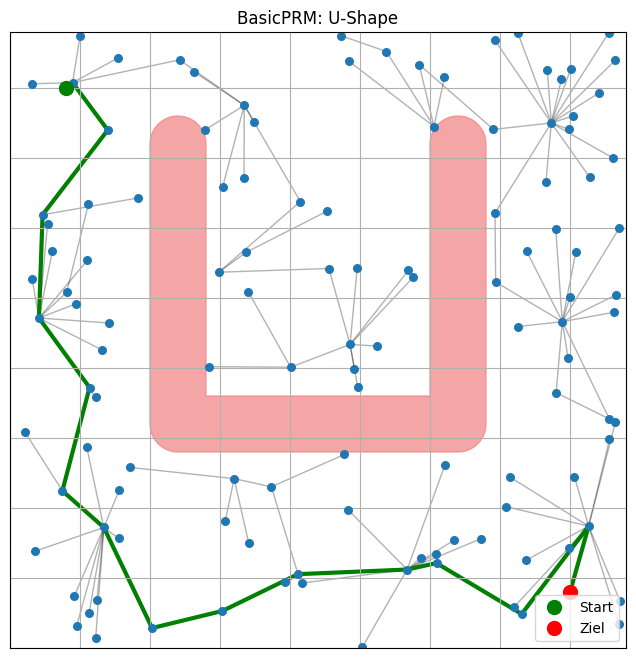


🔍 Szene: L-Shape
✅ Pfad gefunden in Szene: L-Shape, Länge: 22


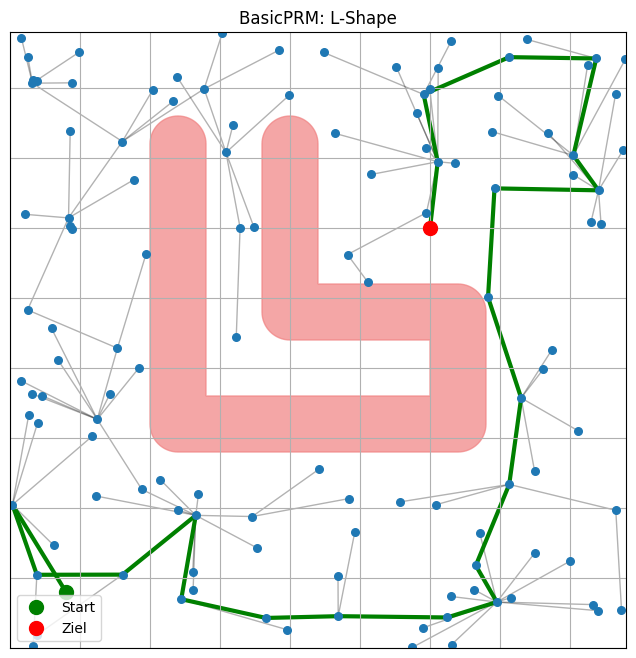


🔍 Szene: Corridor
✅ Pfad gefunden in Szene: Corridor, Länge: 18


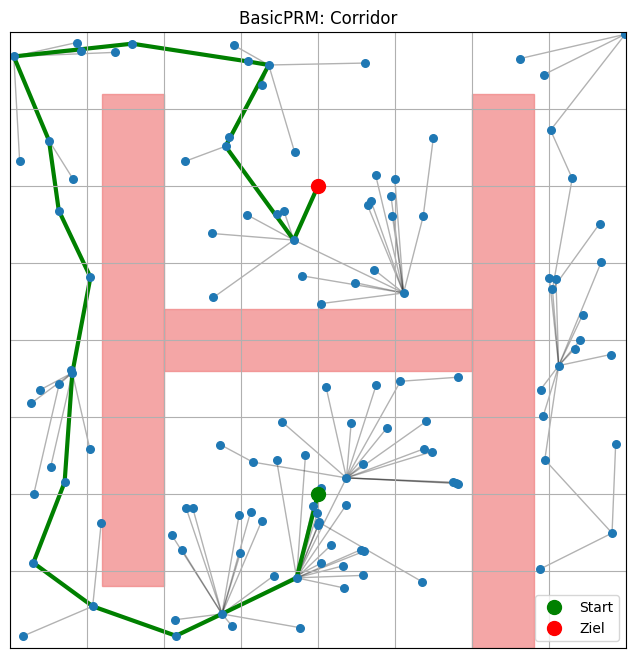


🔍 Szene: Complex Shape
✅ Pfad gefunden in Szene: Complex Shape, Länge: 21


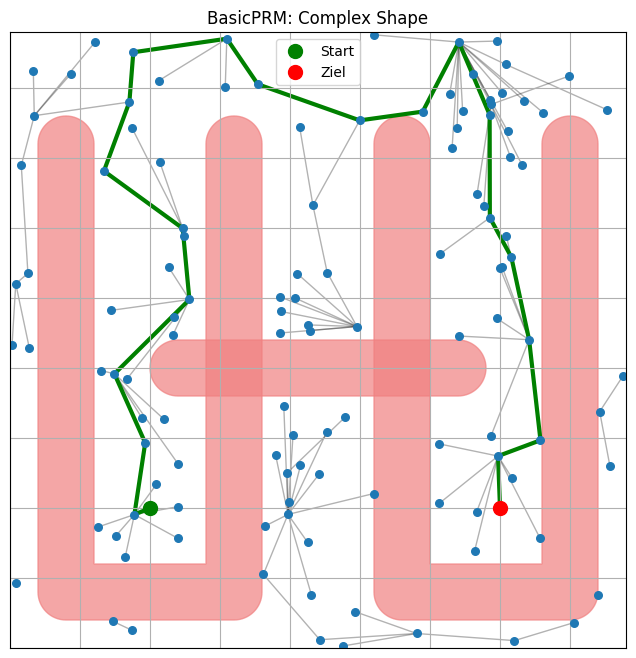


🔍 Szene: Multiple Obstacles
❌ Kein Pfad gefunden in Szene: Multiple Obstacles


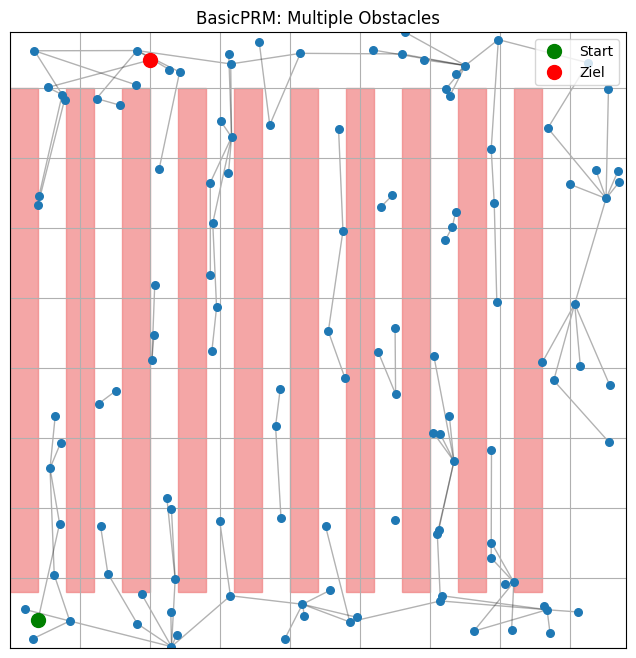


🔍 Szene: Crossed Obstacles
✅ Pfad gefunden in Szene: Crossed Obstacles, Länge: 17


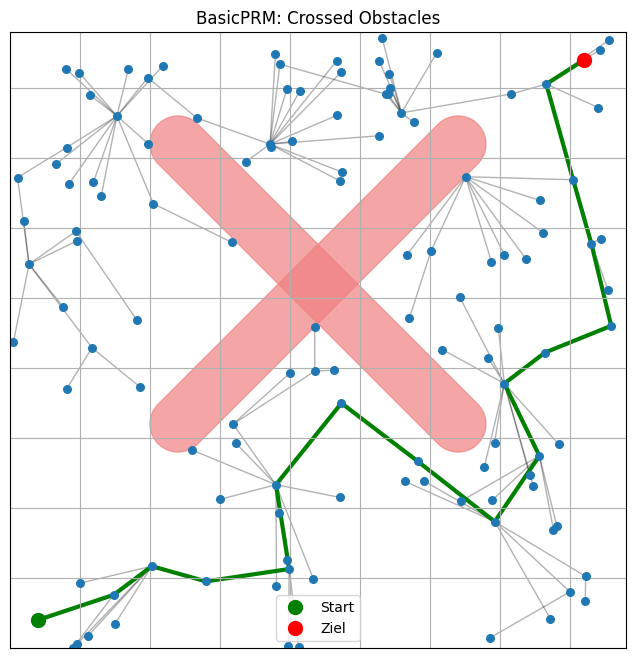


🔍 Szene: Random Obstacles
✅ Pfad gefunden in Szene: Random Obstacles, Länge: 18


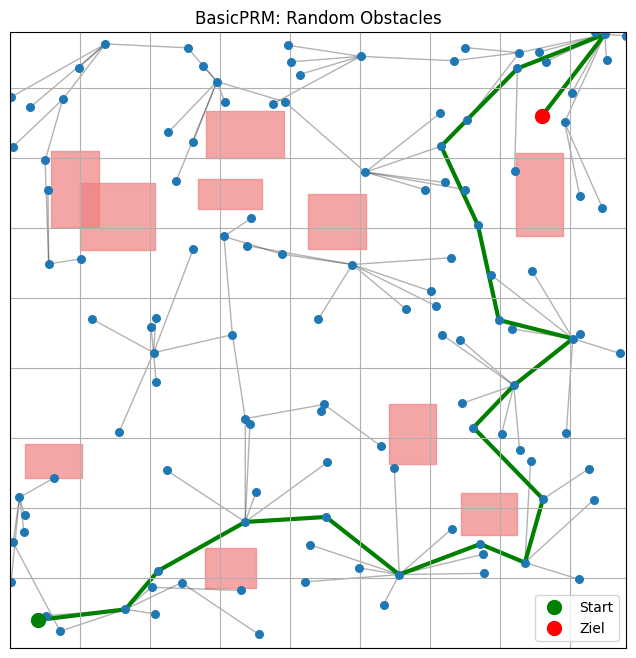

In [4]:
# ---- Alle Szenen durchlaufen + Benchmark ----
scenes = get_all_scenes()
results = []
for scene_name, (scene, limits, (start_pos, goal_pos)) in scenes:
    print(f"\n🔍 Szene: {scene_name}")
    start = [list(start_pos)]
    goal = [list(goal_pos)]

    # CollisionChecker instanziieren
    collision_checker = CollisionChecker(scene, limits)

    # PRM-Planer initialisieren
    planner = BasicPRM(collision_checker, limits)

    # Planung mit Zeitmessung
    t0 = time.time()
    path = planner.plan_path(start, goal, config)
    t1 = time.time()

    coords = planner.get_path_coordinates(path) if path else []
    euclidean_length = sum(euclidean(a, b) for a, b in zip(coords[:-1], coords[1:])) if coords else 0

    if not path:
        print(f"❌ Kein Pfad gefunden in Szene: {scene_name}")
    else:
        print(f"✅ Pfad gefunden in Szene: {scene_name}, Länge: {len(path)}")

    # Visualisierung (optional, kann deaktiviert werden)
    visualize_path(planner, path, scene, limits, start, goal, title=f"BasicPRM: {scene_name}")

    result = {
        "scene": scene_name,
        "hasPath": bool(path),
        "length": len(path) if path else 0,
        "euclidean_length": euclidean_length,
        "time": t1 - t0,
        "nodes": len(planner.graph.nodes),
        "edges": len(planner.graph.edges),
        "roadmap_size": planner.graph.size()  # Gesamtgewicht oder Anzahl der Kanten
    }
    results.append(result)


📊 Benchmark-Ergebnisse:
                scene  hasPath  length  euclidean_length      time  nodes  \
0             U-Shape     True      16         43.260310  0.026963    122   
1             L-Shape     True      22         62.720671  0.029068    122   
2            Corridor     True      18         46.620846  0.031770    122   
3       Complex Shape     True      21         52.582168  0.031155    122   
4  Multiple Obstacles    False       0          0.000000  0.043300    122   
5   Crossed Obstacles     True      17         43.893835  0.030642    122   
6    Random Obstacles     True      18         50.482149  0.034985    122   

   edges  roadmap_size  
0    121           121  
1    121           121  
2    120           120  
3    116           116  
4    112           112  
5    121           121  
6    121           121  
💾 Rohdaten gespeichert unter: benchmark_results/BasicPRM_results.csv


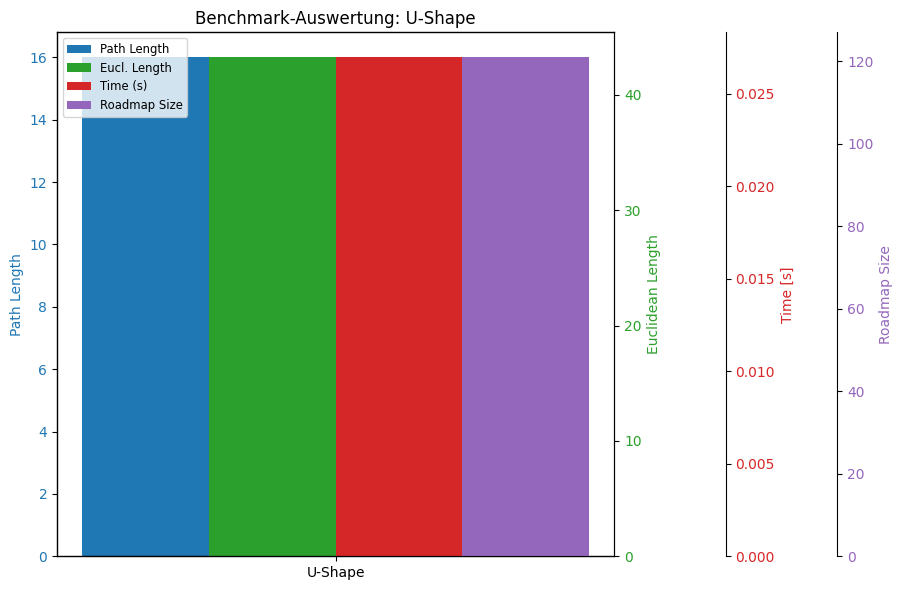

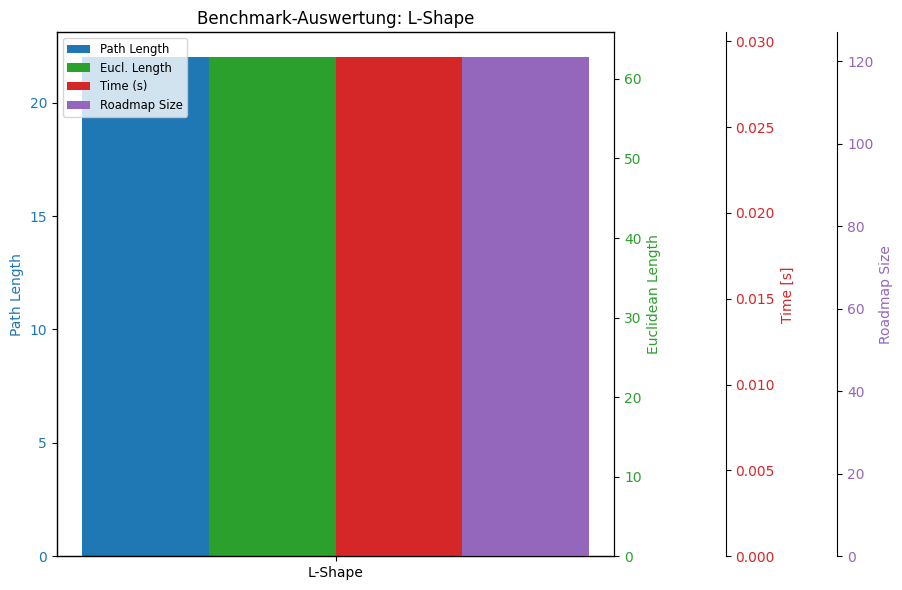

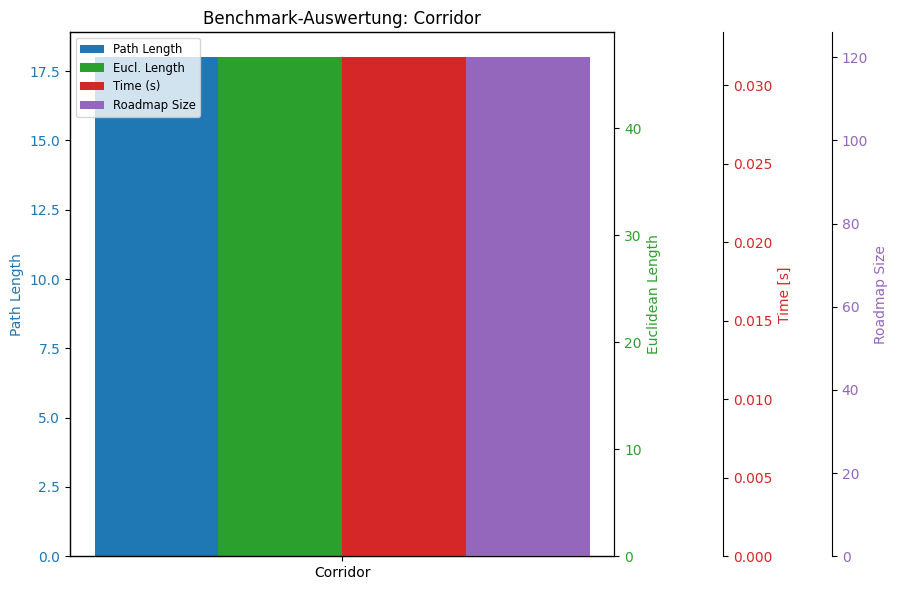

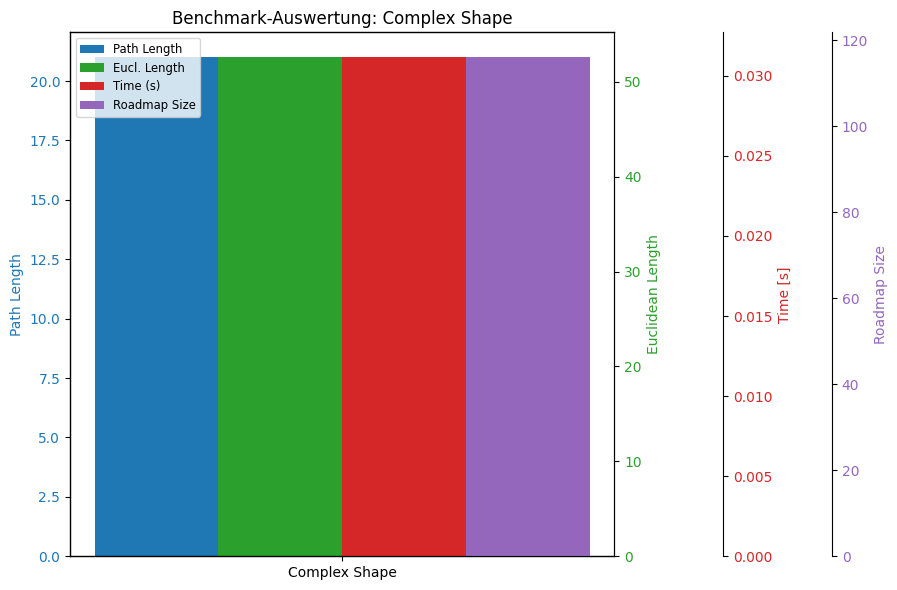

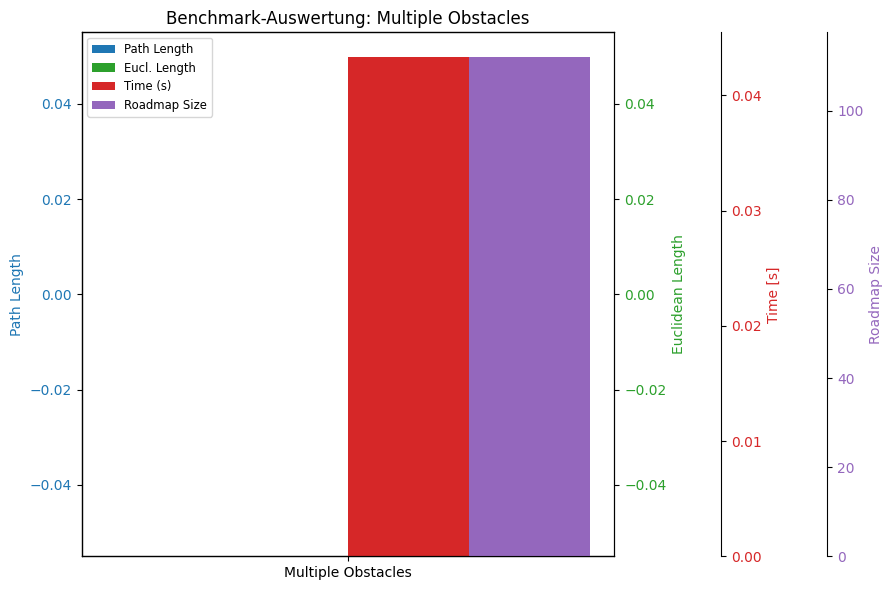

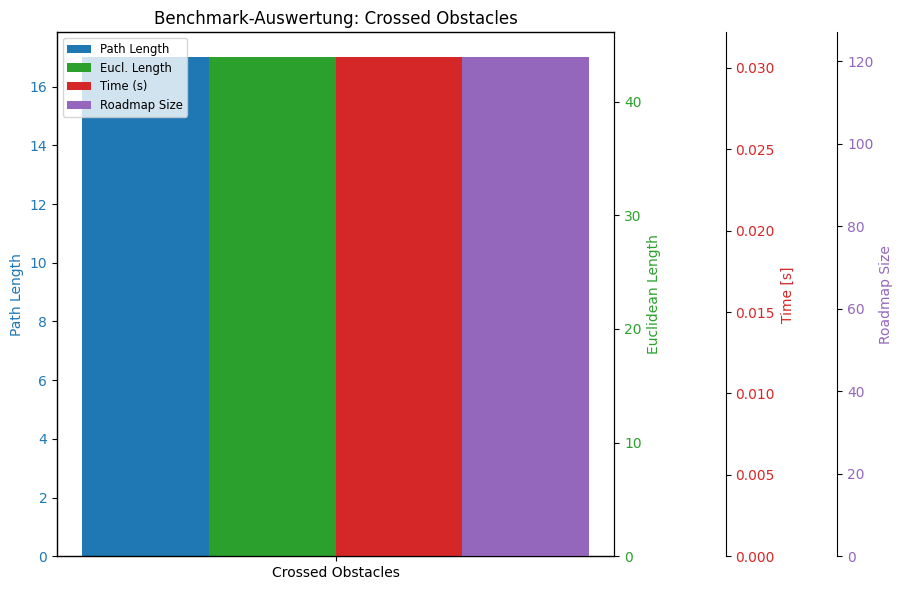

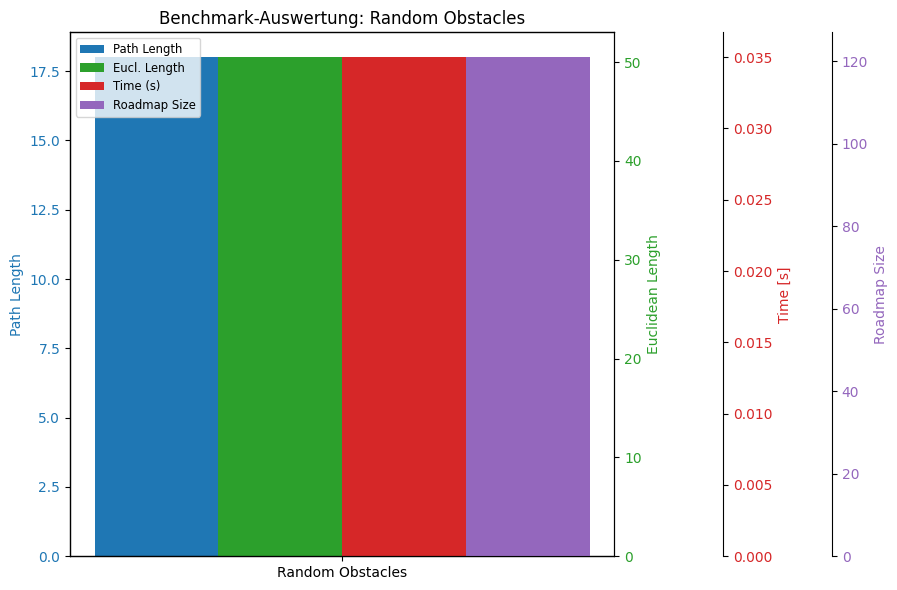

In [5]:
# Ergebnisse als DataFrame
import os
result_df = pd.DataFrame(results)
print("\n📊 Benchmark-Ergebnisse:")
print(result_df)

# Speicherpfad
results_dir = "benchmark_results"
os.makedirs(results_dir, exist_ok=True)

# Dateiname für BasicPRM
csv_path = os.path.join(results_dir, "BasicPRM_results.csv")

# Speichern
result_df.to_csv(csv_path, index=False)
print(f"💾 Rohdaten gespeichert unter: {csv_path}")

# Optional: Plot der Auswertung
# Optional: Verbesserte Visualisierung pro Szene
for scene in result_df["scene"].unique():
    df = result_df[result_df["scene"] == scene]
    fig, ax1 = plt.subplots(figsize=(10, 6))
    width = 0.2
    idx = np.arange(1)

    # Primäre Metriken
    ax1.bar(idx, df["length"], width, label="Path Length", color="#1f77b4")
    ax1.set_ylabel("Path Length", color="#1f77b4")
    ax1.tick_params(axis='y', labelcolor="#1f77b4")

    # Sekundäre Metrik: euklidische Pfadlänge
    ax2 = ax1.twinx()
    ax2.bar(idx + width, df["euclidean_length"], width, label="Eucl. Length", color="#2ca02c")
    ax2.set_ylabel("Euclidean Length", color="#2ca02c")
    ax2.tick_params(axis='y', labelcolor="#2ca02c")

    # Dritte Achse: Zeit
    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('axes', 1.2))
    ax3.bar(idx + 2*width, df["time"], width, label="Time (s)", color="#d62728")
    ax3.set_ylabel("Time [s]", color="#d62728")
    ax3.tick_params(axis='y', labelcolor="#d62728")

    # Vierte Achse: Roadmap-Größe
    ax4 = ax1.twinx()
    ax4.spines['right'].set_position(('axes', 1.4))
    ax4.bar(idx + 3*width, df["roadmap_size"], width, label="Roadmap Size", color="#9467bd")
    ax4.set_ylabel("Roadmap Size", color="#9467bd")
    ax4.tick_params(axis='y', labelcolor="#9467bd")

    # Achsen und Legenden
    ax1.set_xticks(idx + 1.5 * width)
    ax1.set_xticklabels([scene])
    ax1.set_title(f"Benchmark-Auswertung: {scene}")

    # Alle Legenden vereinen
    handles, labels = [], []
    for ax in [ax1, ax2, ax3, ax4]:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    ax1.legend(handles, labels, loc="upper left", fontsize="small")

    plt.tight_layout()
    plt.show()



In [6]:
from lectures.IPPlanarManipulator import PlanarRobot
from lectures.IPEnvironmentKin import KinChainCollisionChecker, planarRobotVisualize
from planners.basic_prm_robot import BasicPRMRobot

import matplotlib.pyplot as plt
from shapely.geometry import LineString

obstacles = dict()
obstacles["wall_left"]   = LineString([(-1.5, 0), (-1.5, 2.5)]).buffer(0.2)
#obstacles["wall_right"]  = LineString([(2.5, 0), (2.8, 2.5)]).buffer(0.2)

joint_limits = [(-0.6, 0.6), (-0.5, 0.6)]
robot = PlanarRobot(n_joints=2)
env = KinChainCollisionChecker(robot, obstacles, fk_resolution=0.2)

# Start- und Zielkonfigurationen als Listen definieren
start_q = [[-0.5, 0.1]]  # Liste von Listen
goal_q = [[np.pi/2, np.pi/5]]  # Liste von Listen

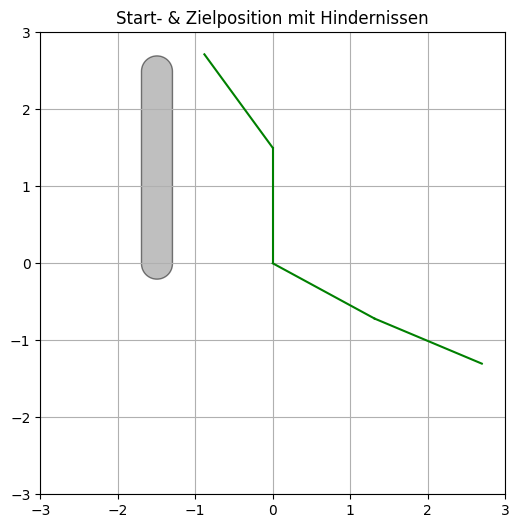

In [7]:
from matplotlib.patches import Polygon as mplPolygon
from matplotlib.collections import PatchCollection

# Visualisierung
fig, ax = plt.subplots(figsize=(6, 6))
ax.set_xlim([-3, 3])
ax.set_ylim([-3, 3])

# Shapely-Hindernisse direkt plotten
patches = []
for poly in obstacles.values():
    coords = list(poly.exterior.coords)
    patches.append(mplPolygon(coords, closed=True))
pc = PatchCollection(patches, facecolor='gray', edgecolor='black', alpha=0.5)
ax.add_collection(pc)

# Roboterbewegung zeigen
# Roboterbewegung zeigen
robot.move(start_q[0])  # Statt start_q
planarRobotVisualize(robot, ax)
robot.move(goal_q[0])   # Statt goal_q

planarRobotVisualize(robot, ax)

plt.title("Start- & Zielposition mit Hindernissen")
plt.grid(True)
plt.show()


In [8]:
# Planer konfigurieren
planner = BasicPRMRobot(env)
config = {"numNodes": 100, "radius": 3.5}

# Pfadplanung durchführen
solution = planner.plan_path(start_q, goal_q, config)

print("✅ Lösung:", solution)
print("Länge der Lösung:", len(solution))

✅ Lösung: ['start', 40, 23, 'goal']
Länge der Lösung: 4
